In [1]:
import os
from pathlib import Path
import datetime
import json

import ee
import geemap
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
## Make sure you're using an environment with geemap
import sys
print('environment:',  sys.executable.split('/')[-3])

environment: nigeria-crop-mask-gpu


## 1. Validation points

In [3]:
gdf = gpd.read_file(Path('../data/features/nigeria-cropharvest/labels.geojson'))
gdf

is_crop        lat        lon  index  identifier     new_set  \
0           0  13.062977   7.169715      0           0  validation   
1           0   9.861582   5.029259      1           1    training   
2           0  10.442239  11.673885      2           2     testing   
3           0   6.506252   6.584187      3           3    training   
4           0   7.980531   7.099293      4           4     testing   
...       ...        ...        ...    ...         ...         ...   
1822        0  11.505429   6.910431   1822        1822  validation   
1823        0  13.281881  13.412151   1823        1823  validation   
1824        0   8.912081   3.703954   1824        1824     testing   
1825        1   8.653739   4.971758   1825        1825  validation   
1826        1   9.802278  12.565271   1826        1826    training   

      start_date    end_date export_end_date  dataset  \
0     2019-04-03  2020-03-28      2020-03-28  nigeria   
1     2019-04-03  2020-03-28      2020-03-28  nigeria   
2     2019-04-03  2020-03-28      2020-03-28  nigeria   
3     2019-04-03  2020-03-28      2020-03-28  nigeria   
4     2019-04-03  2020-03-28      2020-03-28  nigeria   
...          ...         ...             ...      ...   
1822  2019-04-03  2020-03-28      2020-03-28  nigeria   
1823  2019-04-03  2020-03-28      2020-03-28  nigeria   
1824  2019-04-03  2020-03-28      2020-03-28  nigeria   
1825  2019-04-03  2020-03-28      2020-03-28  nigeria   
1826  2019-04-03  2020-03-28      2020-03-28  nigeria   

                       export_identifier  is_test label  \
0        0_nigeria_2019-04-03_2020-03-28    False  None   
1        1_nigeria_2019-04-03_2020-03-28    False  None   
2        2_nigeria_2019-04-03_2020-03-28     True  None   
3        3_nigeria_2019-04-03_2020-03-28    False  None   
4        4_nigeria_2019-04-03_2020-03-28     True  None   
...                                  ...      ...   ...   
1822  1822_nigeria_2019-04-03_2020-03-28    False  None   
1823  1823_nigeria_2019-04-03_2020-03-28    False  None   
1824  1824_nigeria_2019-04-03_2020-03-28     True  None   
1825  1825_nigeria_2019-04-03_2020-03-28    False  None   
1826  1826_nigeria_2019-04-03_2020-03-28    False  None   

                       geometry  
0      POINT (7.16971 13.06298)  
1       POINT (5.02926 9.86158)  
2     POINT (11.67388 10.44224)  
3       POINT (6.58419 6.50625)  
4       POINT (7.09929 7.98053)  
...                         ...  
1822   POINT (6.91043 11.50543)  
1823  POINT (13.41215 13.28188)  
1824    POINT (3.70395 8.91208)  
1825    POINT (4.97176 8.65374)  
1826   POINT (12.56527 9.80228)  

[1827 rows x 14 columns]

Fetch validation or testing set and drop missing arrays

In [4]:
arrays_folder = Path('../data/features/nigeria-cropharvest/features/arrays')
existing_arrays_ids = sorted([int(str(path.stem).split('_')[0]) for path in arrays_folder.glob('*.h5')])
missing_files_identifiers = list(set(list(range(1827))) - set(existing_arrays_ids))
missing_files_identifiers

[938, 235, 1645, 1101, 1134]

In [5]:
eval_set = 'testing' # 'validation'
val_gdf = gdf[gdf['new_set'] == eval_set]

# We don't conside the missing h5 files to ensure a fair comparison with the other models
val_gdf = val_gdf.loc[~val_gdf['identifier'].isin(missing_files_identifiers)]
val_gdf

is_crop        lat        lon  index  identifier  new_set  start_date  \
2           0  10.442239  11.673885      2           2  testing  2019-04-03   
4           0   7.980531   7.099293      4           4  testing  2019-04-03   
6           0   8.898685  10.414310      6           6  testing  2019-04-03   
7           1   8.670462   5.551517      7           7  testing  2019-04-03   
16          0   8.369347   9.376651     16          16  testing  2019-04-03   
...       ...        ...        ...    ...         ...      ...         ...   
1811        0  13.160274  12.016438   1811        1811  testing  2019-04-03   
1813        1   9.574509   9.083099   1813        1813  testing  2019-04-03   
1816        1   8.864097   6.457343   1816        1816  testing  2019-04-03   
1819        0   8.261962   9.678086   1819        1819  testing  2019-04-03   
1824        0   8.912081   3.703954   1824        1824  testing  2019-04-03   

        end_date export_end_date  dataset                   export_identifier  \
2     2020-03-28      2020-03-28  nigeria     2_nigeria_2019-04-03_2020-03-28   
4     2020-03-28      2020-03-28  nigeria     4_nigeria_2019-04-03_2020-03-28   
6     2020-03-28      2020-03-28  nigeria     6_nigeria_2019-04-03_2020-03-28   
7     2020-03-28      2020-03-28  nigeria     7_nigeria_2019-04-03_2020-03-28   
16    2020-03-28      2020-03-28  nigeria    16_nigeria_2019-04-03_2020-03-28   
...          ...             ...      ...                                 ...   
1811  2020-03-28      2020-03-28  nigeria  1811_nigeria_2019-04-03_2020-03-28   
1813  2020-03-28      2020-03-28  nigeria  1813_nigeria_2019-04-03_2020-03-28   
1816  2020-03-28      2020-03-28  nigeria  1816_nigeria_2019-04-03_2020-03-28   
1819  2020-03-28      2020-03-28  nigeria  1819_nigeria_2019-04-03_2020-03-28   
1824  2020-03-28      2020-03-28  nigeria  1824_nigeria_2019-04-03_2020-03-28   

      is_test label                   geometry  
2        True  None  POINT (11.67388 10.44224)  
4        True  None    POINT (7.09929 7.98053)  
6        True  None   POINT (10.41431 8.89868)  
7        True  None    POINT (5.55152 8.67046)  
16       True  None    POINT (9.37665 8.36935)  
...       ...   ...                        ...  
1811     True  None  POINT (12.01644 13.16027)  
1813     True  None    POINT (9.08310 9.57451)  
1816     True  None    POINT (6.45734 8.86410)  
1819     True  None    POINT (9.67809 8.26196)  
1824     True  None    POINT (3.70395 8.91208)  

[455 rows x 14 columns]

In [6]:
val_gdf.is_crop.value_counts()

0    272
1    183
Name: is_crop, dtype: int64

<AxesSubplot:>

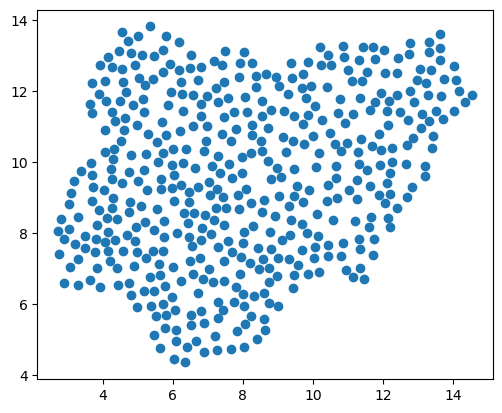

In [7]:
val_gdf.plot()

Transform points to feature collection

In [8]:
## Uncomment and run once
#ee.Authenticate()

In [9]:
ee.Initialize()

In [10]:
val_points = geemap.geopandas_to_ee(val_gdf)
val_points

## 2. Landcover products


- ESA WorldCover
- ESRI 2020
- Dynamic world

In [11]:
# Definitions and helper functions

results = {}
nigeria_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))
true_column = 'is_crop'

# Helper functions
def get_metrics(y_true, y_pred):
    roc_auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print('RF roc-auc test set:', round(roc_auc, 3))
    print('RF precision test set:', round(precision, 3))
    print('RF recall test set:', round(recall, 3))
    print('RF f1-score test set:', round(f1, 3))
    print('RF accuracy test set:', round(acc, 3))
    print('RF confusion matrix:', cm.tolist())

    return {'roc_auc': roc_auc, 'precision': precision, 'recall': recall,
            'f1': f1, 'acc': acc, 'confusion': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}}

def plot_confusion_matrix(tn: int, fp: int, fn: int, tp: int, title: str, save_fig: bool=False) -> ConfusionMatrixDisplay: 
    print(tn, fp, fn, tp)
    cm = np.array([[tn, fp], [fn, tp]])
    cm_display = ConfusionMatrixDisplay(cm)

    fig, ax = plt.subplots(1, 1)
    cm_display.plot(ax=ax)
    labels = ['non-cropland', 'cropland']
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=90)
    fig.suptitle(f'Confusion matrix {title}')

    if save_fig:
        fig.savefig(f'../figures/confusion_matrix_nigeria_{eval_set}_{title.replace(" ", "_")}', facecolor='white')

    return cm_display

class NumpyEncoder(json.JSONEncoder):
# https://bobbyhadz.com/blog/python-typeerror-object-of-type-int64-is-not-json-serializable#:~:text=The%20Python%20%22TypeError%3A%20Object%20of,%2C%20e.g.%20int(my_numpy_int)%20.
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

### 2.1 ESA WorldCover

Access [ESA Global Land Cover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100) landcover product via the GEE catalog.

In [12]:
map_name = 'ESA'
esa = ee.ImageCollection("ESA/WorldCover/v100") #.first()
esa

Image collection

In [13]:
print(esa.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'ESA/WorldCover/v100', 'version': 1685065671563344, 'properties': {'date_range': [1577836800000, 1609459200000], 'period': 0, 'type_name': 'ImageCollection', 'max_mirrored_version': 1634633454597615, 'keywords': ['esa', 'landcover', 'landuse', 'sentinel1-derived', 'sentinel2-derived'], 'description': '<p>The European Space Agency (ESA) WorldCover 10 m 2020 product provides a\nglobal land cover map for 2020 at 10 m resolution based on Sentinel-1 and\nSentinel-2 data. The WorldCover product comes with 11 land cover classes and\nhas been generated in the framework of the ESA WorldCover project, part of the\n5th Earth Observation Envelope Programme (EOEP-5) of the European Space Agency.</p><p>See also:</p><ul><li><a href="https://esa-worldcover.org">ESA WorldCover website</a></li><li><a href="https://esa-worldcover.org/en/data-access">User Manual and Validation Report</a></li></ul><p><b>Provider: <a href="https://esa-worldcover.org/en">ESA/VIT

In [14]:
print('Image collection\'s length:', esa.size().getInfo())

Image collection's length: 1


In [15]:
start, end = esa.getInfo()['properties']['date_range']
utc_to_datetime = lambda x: datetime.datetime.utcfromtimestamp(x/1000.0)
utc_to_datetime(start), utc_to_datetime(end)

(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0))

Get image and info

In [16]:
esa_image = esa.first()
esa_image_info = esa_image.getInfo()
print(esa_image_info)

{'type': 'Image', 'bands': [{'id': 'Map', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [4320000, 1728000], 'crs': 'EPSG:4326', 'crs_transform': [8.333333333333333e-05, 0, -180, 0, -8.333333333333333e-05, 84]}], 'version': 1685065671563344, 'id': 'ESA/WorldCover/v100/2020', 'properties': {'system:time_start': 1577836800000, 'Map_class_names': ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare / sparse vegetation', 'Snow and ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves', 'Moss and lichen'], 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:time_end': 1609459200000, 'Map_class_palette': ['006400', 'ffbb22', 'ffff4c', 'f096ff', 'fa0000', 'b4b4b4', 'f0f0f0', '0064c8', '0096a0', '00cf75', 'fae6a0'], 'Map_class_values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100], 'system:asset_size': 109355097577, 'system:index': '2020'}}


In [17]:
utc_to_datetime(esa_image_info['properties']['system:time_start']), utc_to_datetime(esa_image_info['properties']['system:time_end']) 

(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0))

Get cropland class pixel value

In [18]:
class_name = 'Cropland'
esa_cropland_index = esa_image_info['properties']['Map_class_names'].index(class_name)
cropland_value = esa_cropland_value = esa_image_info['properties']['Map_class_values'][esa_cropland_index]

Evaluate on validation points

In [19]:
pred_column = f'{map_name}pixel_value'
results_val_points = esa_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median()})
results_val_gdf = geemap.ee_to_geopandas(results_val_points)
results_val_gdf.rename(columns={'median': pred_column}, inplace=True)
results_val_gdf

geometry  dataset    end_date export_end_date  \
0    POINT (11.67388 10.44224)  nigeria  2020-03-28      2020-03-28   
1      POINT (7.09929 7.98053)  nigeria  2020-03-28      2020-03-28   
2     POINT (10.41431 8.89868)  nigeria  2020-03-28      2020-03-28   
3      POINT (5.55152 8.67046)  nigeria  2020-03-28      2020-03-28   
4      POINT (9.37665 8.36935)  nigeria  2020-03-28      2020-03-28   
..                         ...      ...         ...             ...   
450  POINT (12.01644 13.16027)  nigeria  2020-03-28      2020-03-28   
451    POINT (9.08310 9.57451)  nigeria  2020-03-28      2020-03-28   
452    POINT (6.45734 8.86410)  nigeria  2020-03-28      2020-03-28   
453    POINT (9.67809 8.26196)  nigeria  2020-03-28      2020-03-28   
454    POINT (3.70395 8.91208)  nigeria  2020-03-28      2020-03-28   

                      export_identifier  identifier  index  is_crop  is_test  \
0       2_nigeria_2019-04-03_2020-03-28           2      2        0     True   
1       4_nigeria_2019-04-03_2020-03-28           4      4        0     True   
2       6_nigeria_2019-04-03_2020-03-28           6      6        0     True   
3       7_nigeria_2019-04-03_2020-03-28           7      7        1     True   
4      16_nigeria_2019-04-03_2020-03-28          16     16        0     True   
..                                  ...         ...    ...      ...      ...   
450  1811_nigeria_2019-04-03_2020-03-28        1811   1811        0     True   
451  1813_nigeria_2019-04-03_2020-03-28        1813   1813        1     True   
452  1816_nigeria_2019-04-03_2020-03-28        1816   1816        1     True   
453  1819_nigeria_2019-04-03_2020-03-28        1819   1819        0     True   
454  1824_nigeria_2019-04-03_2020-03-28        1824   1824        0     True   

           lat        lon  ESApixel_value  new_set  start_date  
0    10.442239  11.673885              30  testing  2019-04-03  
1     7.980531   7.099293              20  testing  2019-04-03  
2     8.898685  10.414310              20  testing  2019-04-03  
3     8.670462   5.551517              30  testing  2019-04-03  
4     8.369347   9.376651              20  testing  2019-04-03  
..         ...        ...             ...      ...         ...  
450  13.160274  12.016438              30  testing  2019-04-03  
451   9.574509   9.083099              40  testing  2019-04-03  
452   8.864097   6.457343              60  testing  2019-04-03  
453   8.261962   9.678086              30  testing  2019-04-03  
454   8.912081   3.703954              20  testing  2019-04-03  

[455 rows x 14 columns]

In [20]:
results_val_gdf[pred_column].value_counts()

40    154
20     94
10     89
30     86
60     13
95      6
80      6
50      4
90      3
Name: ESApixel_value, dtype: int64

Confusion matrix

In [21]:
y_true = results_val_gdf[true_column].to_numpy()
y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
results[map_name] = get_metrics(y_true, y_pred)
assert(len(results_val_gdf) == sum(results[map_name]['confusion'].values()))
results

RF roc-auc test set: 0.852
RF precision test set: 0.903
RF recall test set: 0.76
RF f1-score test set: 0.825
RF accuracy test set: 0.87
RF confusion matrix: [[257, 15], [44, 139]]


{'ESA': {'roc_auc': 0.8522078913532626,
  'precision': 0.9025974025974026,
  'recall': 0.7595628415300546,
  'f1': 0.8249258160237389,
  'acc': 0.8703296703296703,
  'confusion': {'tn': 257, 'fp': 15, 'fn': 44, 'tp': 139}}}

In [22]:
assert(len(results_val_gdf) == sum(results[map_name]['confusion'].values()))

257 15 44 139


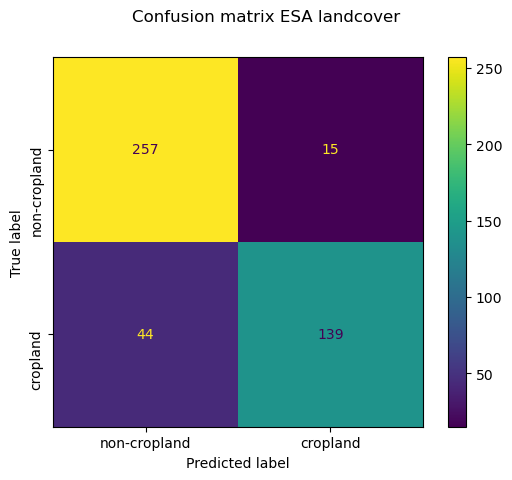

In [23]:
plot_confusion_matrix(**results[map_name]['confusion'], title='ESA landcover', save_fig=True)

**Visualization**

In [24]:
Map = geemap.Map()

Map.setCenter(9.136, 7.433, 6)

esa_vis = {'bands': ['Map']}

Map.addLayer(esa_image.clip(nigeria_boundaries), esa_vis, "ESA Land Cover")
Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')

Map.addLayer(val_points, {}, "Validation points")

Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

### 2.2 ESRI 2020

Access [ESRI 2020 Global Land Cover](https://samapriya.github.io/awesome-gee-community-datasets/projects/esrilc2020/) landcover product via a community added public asset in GEE catalog.

In [25]:
map_name = 'ESRI'
esri = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m")
esri_info = esri.getInfo()
esri_info

{'type': 'ImageCollection',
 'bands': [],
 'version': 1624668441802946,
 'id': 'projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m',
 'features': [{'type': 'Image',
   'bands': [{'id': 'b1',
     'data_type': {'type': 'PixelType',
      'precision': 'int',
      'min': 0,
      'max': 255},
     'dimensions': [27922, 32025],
     'crs': 'EPSG:32701',
     'crs_transform': [10,
      0,
      365215.04551425716,
      0,
      -10,
      1381432.0991431829]}],
   'version': 1624644462274581,
   'id': 'projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m/01C_20200101-20210101',
   'properties': {'num_bands': 1,
    'id_no': '01C_20200101-20210101',
    'ysize': 32025,
    'system:footprint': {'type': 'LinearRing',
     'coordinates': [[176.2162454956937, -79.72499763854299],
      [175.97416745526368, -80.08104203780834],
      [175.71390916290045, -80.43697590455974],
      [-169.1984008146848, -80.42578331626476],
      [-169.4766544104135, -80.07025809952935],
      

In [26]:
print('Image collection\'s length:', esri.size().getInfo())

Image collection's length: 728


In [27]:
esri_image = esri.mosaic()
esri_image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'b1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Transform dataframe with results to Feature Collection (setting crs first)

In [28]:
results_val_gdf = results_val_gdf.set_crs('EPSG:4326')
results_val_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
val_points = geemap.geopandas_to_ee(results_val_gdf) # convert dataframe with ESA results to GEE feature collection (so that we resuse dataframe instead of merging results)
val_points

**Evaluate on validation points**

In [30]:
pred_column = f'{map_name}_pixel_value'
results_val_points = esri_image.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
results_val_gdf.rename(columns={'median': pred_column}, inplace=True)
results_val_gdf

geometry  ESApixel_value  dataset    end_date  \
0    POINT (11.67388 10.44224)              30  nigeria  2020-03-28   
1      POINT (7.09929 7.98053)              20  nigeria  2020-03-28   
2     POINT (10.41431 8.89868)              20  nigeria  2020-03-28   
3      POINT (5.55152 8.67046)              30  nigeria  2020-03-28   
4      POINT (9.37665 8.36935)              20  nigeria  2020-03-28   
..                         ...             ...      ...         ...   
450  POINT (12.01644 13.16027)              30  nigeria  2020-03-28   
451    POINT (9.08310 9.57451)              40  nigeria  2020-03-28   
452    POINT (6.45734 8.86410)              60  nigeria  2020-03-28   
453    POINT (9.67809 8.26196)              30  nigeria  2020-03-28   
454    POINT (3.70395 8.91208)              20  nigeria  2020-03-28   

    export_end_date                   export_identifier  identifier  index  \
0        2020-03-28     2_nigeria_2019-04-03_2020-03-28           2      2   
1        2020-03-28     4_nigeria_2019-04-03_2020-03-28           4      4   
2        2020-03-28     6_nigeria_2019-04-03_2020-03-28           6      6   
3        2020-03-28     7_nigeria_2019-04-03_2020-03-28           7      7   
4        2020-03-28    16_nigeria_2019-04-03_2020-03-28          16     16   
..              ...                                 ...         ...    ...   
450      2020-03-28  1811_nigeria_2019-04-03_2020-03-28        1811   1811   
451      2020-03-28  1813_nigeria_2019-04-03_2020-03-28        1813   1813   
452      2020-03-28  1816_nigeria_2019-04-03_2020-03-28        1816   1816   
453      2020-03-28  1819_nigeria_2019-04-03_2020-03-28        1819   1819   
454      2020-03-28  1824_nigeria_2019-04-03_2020-03-28        1824   1824   

     is_crop  is_test        lat        lon  ESRI_pixel_value  new_set  \
0          0     True  10.442239  11.673885                 6  testing   
1          0     True   7.980531   7.099293                 2  testing   
2          0     True   8.898685  10.414310                 2  testing   
3          1     True   8.670462   5.551517                 5  testing   
4          0     True   8.369347   9.376651                 6  testing   
..       ...      ...        ...        ...               ...      ...   
450        0     True  13.160274  12.016438                 6  testing   
451        1     True   9.574509   9.083099                 6  testing   
452        1     True   8.864097   6.457343                 6  testing   
453        0     True   8.261962   9.678086                 6  testing   
454        0     True   8.912081   3.703954                 6  testing   

     start_date  
0    2019-04-03  
1    2019-04-03  
2    2019-04-03  
3    2019-04-03  
4    2019-04-03  
..          ...  
450  2019-04-03  
451  2019-04-03  
452  2019-04-03  
453  2019-04-03  
454  2019-04-03  

[455 rows x 15 columns]

In [31]:
results_val_gdf[pred_column].value_counts()

6    270
2    114
5     45
7     10
1      6
4      5
3      4
8      1
Name: ESRI_pixel_value, dtype: int64

Confusion matrix

In [32]:
cropland_value = esri_cropland_value = 5 

In [33]:
y_true = results_val_gdf[true_column].to_numpy()
y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
results[map_name] = get_metrics(y_true, y_pred)
assert(len(results_val_gdf) == sum(results[map_name]['confusion'].values()))
results

RF roc-auc test set: 0.596
RF precision test set: 0.867
RF recall test set: 0.213
RF f1-score test set: 0.342
RF accuracy test set: 0.67
RF confusion matrix: [[266, 6], [144, 39]]


{'ESA': {'roc_auc': 0.8522078913532626,
  'precision': 0.9025974025974026,
  'recall': 0.7595628415300546,
  'f1': 0.8249258160237389,
  'acc': 0.8703296703296703,
  'confusion': {'tn': 257, 'fp': 15, 'fn': 44, 'tp': 139}},
 'ESRI': {'roc_auc': 0.5955279652844745,
  'precision': 0.8666666666666667,
  'recall': 0.21311475409836064,
  'f1': 0.3421052631578947,
  'acc': 0.6703296703296703,
  'confusion': {'tn': 266, 'fp': 6, 'fn': 144, 'tp': 39}}}

266 6 144 39


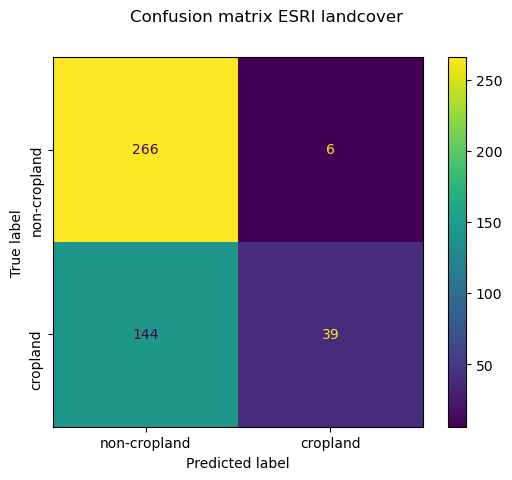

In [34]:
plot_confusion_matrix(**results[map_name]['confusion'], title='ESRI landcover', save_fig=True)

Visualization

In [35]:
Map = geemap.Map()

Map.setCenter(9.136, 7.433, 6)
esri_vis = {
    'min': 1,
    'max': 10,
    'palette': [
        "#1A5BAB",
        "#358221",
        "#A7D282",
        "#87D19E",
        "#FFDB5C",
        "#EECFA8",
        "#ED022A",
        "#EDE9E4",
        "#F2FAFF",
        "#C8C8C8",
    ],
}

Map.addLayer(esri_image.clip(nigeria_boundaries), esri_vis, "ESRI Land Cover")
Map.add_legend(title="ESRI Land Cover", builtin_legend='ESRI_LandCover')

Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

### 2.3 Dynamic World

Access [Dynamic World Land Cover](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1?hl=en) landcover product via the GEE catalog.

In [36]:
map_name = 'DW'
start_date = '2020-01-01'
end_date = '2021-01-01'
dw_class = geemap.dynamic_world(nigeria_boundaries, start_date, end_date, return_type='class')

In [37]:
dw_class.getInfo()

{'type': 'Image',
 'bands': [{'id': 'label_mode',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

Transform dataframe with results to Feature Collection (setting crs first)

In [38]:
results_val_gdf = results_val_gdf.set_crs('EPSG:4326')
results_val_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
val_points = geemap.geopandas_to_ee(results_val_gdf) # convert dataframe with ESA/ESRI results to GEE feature collection (so that we resuse dataframe instead of merging results)
val_points

**Evaluate on validation points**

In [40]:
pred_column = f'{map_name}_pixel_value'
results_val_points = dw_class.reduceRegions(**{'collection': val_points, 'reducer': ee.Reducer.median(), 'scale': 10}) # need to specify a scale for GEE not to complain
results_val_gdf = geemap.ee_to_geopandas(results_val_points)# rewrites previous gdf
results_val_gdf.rename(columns={'median': pred_column}, inplace=True)
results_val_gdf

geometry  ESApixel_value  ESRI_pixel_value  dataset  \
0    POINT (11.67388 10.44224)              30                 6  nigeria   
1      POINT (7.09929 7.98053)              20                 2  nigeria   
2     POINT (10.41431 8.89868)              20                 2  nigeria   
3      POINT (5.55152 8.67046)              30                 5  nigeria   
4      POINT (9.37665 8.36935)              20                 6  nigeria   
..                         ...             ...               ...      ...   
450  POINT (12.01644 13.16027)              30                 6  nigeria   
451    POINT (9.08310 9.57451)              40                 6  nigeria   
452    POINT (6.45734 8.86410)              60                 6  nigeria   
453    POINT (9.67809 8.26196)              30                 6  nigeria   
454    POINT (3.70395 8.91208)              20                 6  nigeria   

       end_date export_end_date                   export_identifier  \
0    2020-03-28      2020-03-28     2_nigeria_2019-04-03_2020-03-28   
1    2020-03-28      2020-03-28     4_nigeria_2019-04-03_2020-03-28   
2    2020-03-28      2020-03-28     6_nigeria_2019-04-03_2020-03-28   
3    2020-03-28      2020-03-28     7_nigeria_2019-04-03_2020-03-28   
4    2020-03-28      2020-03-28    16_nigeria_2019-04-03_2020-03-28   
..          ...             ...                                 ...   
450  2020-03-28      2020-03-28  1811_nigeria_2019-04-03_2020-03-28   
451  2020-03-28      2020-03-28  1813_nigeria_2019-04-03_2020-03-28   
452  2020-03-28      2020-03-28  1816_nigeria_2019-04-03_2020-03-28   
453  2020-03-28      2020-03-28  1819_nigeria_2019-04-03_2020-03-28   
454  2020-03-28      2020-03-28  1824_nigeria_2019-04-03_2020-03-28   

     identifier  index  is_crop  is_test        lat        lon  \
0             2      2        0     True  10.442239  11.673885   
1             4      4        0     True   7.980531   7.099293   
2             6      6        0     True   8.898685  10.414310   
3             7      7        1     True   8.670462   5.551517   
4            16     16        0     True   8.369347   9.376651   
..          ...    ...      ...      ...        ...        ...   
450        1811   1811        0     True  13.160274  12.016438   
451        1813   1813        1     True   9.574509   9.083099   
452        1816   1816        1     True   8.864097   6.457343   
453        1819   1819        0     True   8.261962   9.678086   
454        1824   1824        0     True   8.912081   3.703954   

     DW_pixel_value  new_set  start_date  
0                 5  testing  2019-04-03  
1                 1  testing  2019-04-03  
2                 1  testing  2019-04-03  
3                 5  testing  2019-04-03  
4                 4  testing  2019-04-03  
..              ...      ...         ...  
450               7  testing  2019-04-03  
451               4  testing  2019-04-03  
452               5  testing  2019-04-03  
453               4  testing  2019-04-03  
454               1  testing  2019-04-03  

[455 rows x 16 columns]

In [41]:
results_val_gdf[pred_column].value_counts()

5    167
1    140
4     79
7     47
0     12
6      7
3      2
2      1
Name: DW_pixel_value, dtype: int64

Confusion matrix

In [42]:
cropland_value = dw_cropland_value = 5 

In [43]:
y_true = results_val_gdf[true_column].to_numpy()
y_pred = (results_val_gdf[pred_column] == cropland_value).astype(int).to_numpy()
results[map_name] = get_metrics(y_true, y_pred)
assert(len(results_val_gdf) == sum(results[map_name]['confusion'].values()))
results

RF roc-auc test set: 0.568
RF precision test set: 0.491
RF recall test set: 0.448
RF f1-score test set: 0.469
RF accuracy test set: 0.591
RF confusion matrix: [[187, 85], [101, 82]]


{'ESA': {'roc_auc': 0.8522078913532626,
  'precision': 0.9025974025974026,
  'recall': 0.7595628415300546,
  'f1': 0.8249258160237389,
  'acc': 0.8703296703296703,
  'confusion': {'tn': 257, 'fp': 15, 'fn': 44, 'tp': 139}},
 'ESRI': {'roc_auc': 0.5955279652844745,
  'precision': 0.8666666666666667,
  'recall': 0.21311475409836064,
  'f1': 0.3421052631578947,
  'acc': 0.6703296703296703,
  'confusion': {'tn': 266, 'fp': 6, 'fn': 144, 'tp': 39}},
 'DW': {'roc_auc': 0.5677937158469946,
  'precision': 0.49101796407185627,
  'recall': 0.44808743169398907,
  'f1': 0.4685714285714286,
  'acc': 0.5912087912087912,
  'confusion': {'tn': 187, 'fp': 85, 'fn': 101, 'tp': 82}}}

187 85 101 82


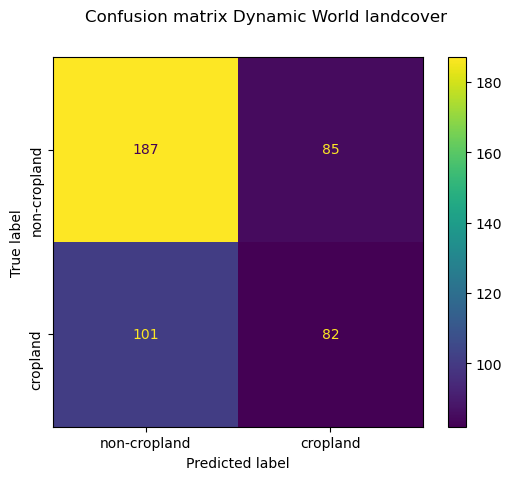

In [44]:
plot_confusion_matrix(**results[map_name]['confusion'], title='Dynamic World landcover', save_fig=True)

Save results

In [45]:
rel_results_path = Path('../results')
rel_results_path.mkdir(parents=True, exist_ok=True)

with (rel_results_path / f'landcovermaps_nigeria_{eval_set}.json').open('w') as f:
    json.dump(results, f, cls=NumpyEncoder)

Visualization

In [46]:
Map = geemap.Map()
Map.setCenter(9.136, 7.433, 6)

dw_vis = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ],
}

Map.addLayer(dw_class.clip(nigeria_boundaries), dw_vis, 'DW Land Cover', True)

Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map

Map(center=[7.433, 9.136], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [47]:
eval_set = 'validation' # 'validation'
val_gdf = gdf[gdf['new_set'] == eval_set]
val_gdf

is_crop        lat        lon  index  identifier     new_set  \
0           0  13.062977   7.169715      0           0  validation   
9           0   6.490525  11.100182      9           9  validation   
12          0   9.070987   4.165518     12          12  validation   
17          0   9.616789   4.548864     17          17  validation   
20          1  11.729388   8.818662     20          20  validation   
...       ...        ...        ...    ...         ...         ...   
1820        0  10.631163   9.298323   1820        1820  validation   
1821        1  12.432710  12.860431   1821        1821  validation   
1822        0  11.505429   6.910431   1822        1822  validation   
1823        0  13.281881  13.412151   1823        1823  validation   
1825        1   8.653739   4.971758   1825        1825  validation   

      start_date    end_date export_end_date  dataset  \
0     2019-04-03  2020-03-28      2020-03-28  nigeria   
9     2019-04-03  2020-03-28      2020-03-28  nigeria   
12    2019-04-03  2020-03-28      2020-03-28  nigeria   
17    2019-04-03  2020-03-28      2020-03-28  nigeria   
20    2019-04-03  2020-03-28      2020-03-28  nigeria   
...          ...         ...             ...      ...   
1820  2019-04-03  2020-03-28      2020-03-28  nigeria   
1821  2019-04-03  2020-03-28      2020-03-28  nigeria   
1822  2019-04-03  2020-03-28      2020-03-28  nigeria   
1823  2019-04-03  2020-03-28      2020-03-28  nigeria   
1825  2019-04-03  2020-03-28      2020-03-28  nigeria   

                       export_identifier  is_test label  \
0        0_nigeria_2019-04-03_2020-03-28    False  None   
9        9_nigeria_2019-04-03_2020-03-28    False  None   
12      12_nigeria_2019-04-03_2020-03-28    False  None   
17      17_nigeria_2019-04-03_2020-03-28    False  None   
20      20_nigeria_2019-04-03_2020-03-28    False  None   
...                                  ...      ...   ...   
1820  1820_nigeria_2019-04-03_2020-03-28    False  None   
1821  1821_nigeria_2019-04-03_2020-03-28    False  None   
1822  1822_nigeria_2019-04-03_2020-03-28    False  None   
1823  1823_nigeria_2019-04-03_2020-03-28    False  None   
1825  1825_nigeria_2019-04-03_2020-03-28    False  None   

                       geometry  
0      POINT (7.16971 13.06298)  
9      POINT (11.10018 6.49052)  
12      POINT (4.16552 9.07099)  
17      POINT (4.54886 9.61679)  
20     POINT (8.81866 11.72939)  
...                         ...  
1820   POINT (9.29832 10.63116)  
1821  POINT (12.86043 12.43271)  
1822   POINT (6.91043 11.50543)  
1823  POINT (13.41215 13.28188)  
1825    POINT (4.97176 8.65374)  

[456 rows x 14 columns]